In [ ]:
!pip install PyWavelets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os, sys
import glob
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt

proj_path = '/content/drive/MyDrive/STAT685/project'
control_path = os.path.join(proj_path, 'DATA/Control/')
control_files = glob.glob(os.path.join(control_path, "Control*.csv"))
control_files.sort()
print(control_files[0:5])

['/content/drive/MyDrive/STAT685/project/DATA/Control/Control daf-0181.csv', '/content/drive/MyDrive/STAT685/project/DATA/Control/Control daf-0182.csv', '/content/drive/MyDrive/STAT685/project/DATA/Control/Control daf-0183.csv', '/content/drive/MyDrive/STAT685/project/DATA/Control/Control daf-0184.csv', '/content/drive/MyDrive/STAT685/project/DATA/Control/Control daf-0185.csv']


In [3]:
this_file = control_files[0]
prot_spec = pd.read_csv(this_file)
print(prot_spec.head())

prot_spec_ar = np.array(prot_spec['Intensity'])
print(prot_spec_ar[0:5])

            M/Z  Intensity
0 -7.860261e-05   4.168929
1  2.177358e-07   4.132730
2  9.602147e-05   4.096531
3  3.660138e-04   4.154852
4  8.101948e-04   4.054299
[4.1689291 4.13273   4.0965309 4.1548517 4.0542986]


In [4]:
# trying to make a custom wavelet filter bank

#       0.038580777747887  -0.126969125396205  -0.077161555495774   0.607491641385684 ...
#       0.745687558934434   0.226584265197069

prof_h = np.array([0.038580777747887, -0.126969125396205, -0.077161555495774, 
          0.607491641385684, 0.745687558934434, 0.226584265197069])

prof_d_hi = np.flip(prof_h) * np.array([-1, 1] * 3)
prof_r_lo = np.flip(prof_h)
prof_r_hi = np.flip(prof_d_hi)

# filter_bank = [dec_lo, dec_hi, rec_lo, rec_hi]
# myWavelet = pywt.Wavelet(name="myHaarWavelet", filter_bank=filter_bank)

filter_bank = [prof_h, prof_d_hi, prof_r_lo, prof_r_hi]
profWavelet = pywt.Wavelet(name="profWavelet", filter_bank=filter_bank)

[1, -1, 1, -1, 1, -1]

In [5]:
# do one window

win_size = 1024
step_size = 500
nlevels = 10

# Python starts at 0, and the last index is not inclusive
# say I want k1 = 6, then py_k1 = k1 - 1
k1 = 7 # in py index, I want k1-1 
k2 = 11 # want py index k2-1, but use this as-is because last index is not inclusive
k1k2 = np.arange(k1-1, k2)

starts = np.arange(0, len(prot_spec_ar)-win_size-1, step_size)
start = starts[0]
prot_sub = prot_spec_ar[start:(start+win_size)]

# figure out some stuff about wavelet filters and max levels

pywt.Wavelet('db3').filter_bank
pywt.dwt_max_level(1024, 'db3')

# pywt.pad(x, pad_widths, mode)
prot_padded = pywt.pad(prot_sub, (6, len(prot_sub)), 'periodic')
len(prot_padded)
pywt.dwt_max_level(len(prot_padded), 'db3')

# what is the max levels? does it really matter that much? See GitHub issues for some ideas:
# https://github.com/PyWavelets/pywt/issues/396
# https://github.com/PyWavelets/pywt/issues/306
# https://www.mathworks.com/help/wavelet/ref/wmaxlev.html

8

In [8]:
#  pywt.wavedec(data, wavelet, mode='symmetric', level=None, axis=-1)
# if I do "level = None", then it will do the max possible
# 'db3' or profWavelet
mdwt = pywt.wavedec(prot_sub, profWavelet, 'periodization', level = nlevels)

wave_spec = np.array([np.log2(np.mean(coefs**2)) for coefs in mdwt])
wave_spec

# periodic, db3, nlevels=10
# /usr/local/lib/python3.8/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
#   warnings.warn(

# array([17.43587133, 12.84507321, 12.8718914 , 12.12747865, 12.52361179,
#        12.04589963,  9.48503547,  8.38186918,  7.14915571,  5.0915446 ,
#         1.37392362])

/usr/local/lib/python3.8/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  warnings.warn(


array([16.59373324, 12.47589867, 13.09023911,  9.52905443, 10.33837476,
       10.06781195,  9.5151689 ,  8.5355197 ,  7.14694708,  4.0745698 ,
        1.35603092])

-2.077922586055163


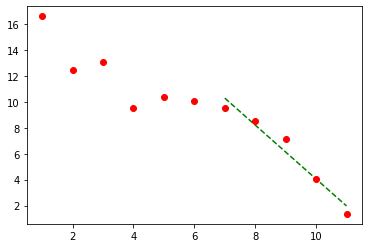

In [9]:
levels = np.arange(1, nlevels+2) # 1 extra wavelet coefficient + 1 for indexing

tofit_X = levels[k1k2]
tofit_X = np.vstack([tofit_X, np.ones(len(tofit_X))]).T
tofit_Y = wave_spec[k1k2]
slopeint, _, _, _ = np.linalg.lstsq(tofit_X, tofit_Y, rcond = None)
print(slopeint[0])

plt.plot(levels[k1k2], levels[k1k2] * slopeint[0] + slopeint[1], 'g--')
plt.plot(levels, wave_spec, 'ro')
plt.show()